In [36]:
# ==================================================
# LIBRARY
# ==================================================

!pip install Sastrawi
!pip install gensim

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')


from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


from gensim import corpora
from gensim.models import LdaModel

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [37]:
# ==================================================
# DATA
# ==================================================
df = pd.read_csv("data_labeled_250 (2).csv")
df.head()

,userName,content,score,reviewCreatedVersion,at,replyContent,repliedAt,content_casefold,content_tokenized,content_stemmed,content_filtered,label
0,Nur kholifah,ya ampun sering banget ngga bisa dibuka,3,11.15.1,2025-10-07 15:09:44,NaN,NaN,ya ampun sering banget ngga bisa dibuka,"['iya', 'ampun', 'sering', 'banget', 'tidak', ...","['iya', 'ampun', 'sering', 'banget', 'tidak', ...",['ampun'],neutral
1,Ridestiana,kok sekarang malah gak bisa offline sih padaha...,2,11.15.1,2025-10-07 13:34:44,NaN,NaN,kok sekarang malah gak bisa offline sih padaha...,"['kok', 'sekarang', 'malah', 'tidak', 'bisa', ...","['kok', 'sekarang', 'malah', 'tidak', 'bisa', ...","['offline', 'dimasukin', 'daftar', 'offline', ...",negative
2,Gracesiella Amanda,Gw gak masalah sih ini mau di duitin terus tap...,1,11.15.1,2025-10-07 13:13:07,NaN,NaN,gw gak masalah sih ini mau di duitin terus tap...,"['aku', 'tidak', 'masalah', 'sih', 'ini', 'mau...","['aku', 'tidak', 'masalah', 'sih', 'ini', 'mau...","['masalah', 'duitin', 'bobrok', 'edit', 'cerit...",negative
3,E L I O,ini kenapa sekarang gak bisa naruh link di inf...,1,11.12.2,2025-10-07 08:01:06,NaN,NaN,ini kenapa sekarang gak bisa naruh link di inf...,"['ini', 'kenapa', 'sekarang', 'tidak', 'bisa',...","['ini', 'kenapa', 'sekarang', 'tidak', 'bisa',...","['naruh', 'link', 'akun', 'update', 'naruh', '...",negative
4,Dian a.l,Ni aplikasi ada masalah apa sih? sinyal gua ba...,1,11.15.1,2025-10-07 06:05:52,NaN,NaN,ni aplikasi ada masalah apa sih? sinyal gua ba...,"['ini', 'aplikasi', 'ada', 'masalah', 'apa', '...","['ini', 'aplikasi', 'ada', 'masalah', 'apa', '...","['masalah', 'sinyal', 'beranda', 'nunjukin', '...",negative


In [49]:
# ==================================================
# PREPROCESSING
# ==================================================

# Slang dictionary
slang_dict = {
    "aj": "aja",
    "ak": "aku",
    "anj": "wow",
    "anjay": "wow",
    "anjir": "wow",
    "apk": "aplikasi",
    "apl": "aplikasi",
    "apknya": "aplikasi",
    "app": "aplikasi",
    "aq": "aku",
    "baca": "baca",
    "baguss": "bagus",
    "bg": "bang",
    "bgs": "bagus",
    "bgt": "banget",
    "bgtt": "banget",
    "bgus": "bagus",
    "bkin": "bikin",
    "blm": "belum",
    "bngt": "banget",
    "bnr": "benar",
    "bro": "teman",
    "bs": "bisa",
    "bsa": "bisa",
    'bagu': 'bagus',
    "bugnya": "bug",
    "cm": "cuma",
    "cmn": "cuma",
    "cuman": "cuma",
    "cuy": "teman",
    "dek": "adik",
    "dibaca": "dibaca",
    "dibalikin": "dikembalikan",
    "dibikin": "dibuat",
    "dibuat": "dibuat",
    "dibuka": "dibuka",
    "dicepat": "dipercepat",
    "dik": "adik",
    "dimasukin": "dimasukkan",
    "dipulihkan": "dipulihkan",
    "disave": "disimpan",
    "disimpen": "disimpan",
    "ditagih": "ditagih",
    "ditaruh": "ditaruh",
    "ditulis": "ditulis",
    "diupdate": "diperbarui",
    "dongg": "dong",
    "donggg": "dong",
    "dongs": "dong",
    "dongz": "dong",
    "dr": "dari",
    "draf": "draft",
    "dri": "dari",
    "duit": "uang",
    "emang": "memang",
    "eror": "error",
    "g": "tidak",
    "ga": "tidak",
    "gak": "tidak",
    "gatau": "tidak tahu",
    "gbs": "gabisa",
    "gk": "tidak",
    "gmn": "gimana",
    "gt": "gitu",
    "gua": "aku",
    "gue": "aku",
    "gw": "aku",
    "hrs": "harus",
    "ilang": "hilang",
    "instal": "install",
    "jaring": "jaringan",
    "jdi": "jadi",
    "jg": "juga",
    "jga": "juga",
    "jls": "jelas",
    "kaga": "tidak",
    "kagak": "tidak",
    "kak": "kakak",
    "kalo": "kalau",
    "karna": "karena",
    "kau": "kamu",
    "kaya": "seperti",
    "kisah": "cerita",
    "klo": "kalau",
    "knp": "kenapa",
    "knpa": "kenapa",
    "ky": "seperti",
    "lgi": "lagi",
    "log": "login",
    "lu": "kamu",
    "makasi": "terima kasih",
    "makasih": "terima kasih",
    "mas": "kakak",
    "mbak": "kakak",
    "mlu": "mulu",
    "moga": "semoga",
    "ngak": "tidak",
    "ngelag": "lag",
    "ngebug": "bug",
    "ngga": "tidak",
    "nggak": "tidak",
    "ngk": "tidak",
    "ni": "ini",
    "ny": "nya",
    "om": "paman",
    "pak": "bapak",
    "pake": "pakai",
    "pdhl": "padahal",
    "perbaikin": "perbaiki",
    "pke": "pakai",
    "pl": "tolong",
    "plik": "tolong",
    "plis": "tolong",
    "pliss": "tolong",
    "pls": "tolong",
    "sampe": "sampai",
    "sdh": "sudah",
    "sis": "teman",
    "skrg": "sekarang",
    "skrng": "sekarang",
    "sm": "sama",
    "sy": "saya",
    "tante": "bibi",
    "tdk": "tidak",
    "tetep": "tetap",
    "tlg": "tolong",
    "tlng": "tolong",
    "tpi": "tapi",
    "tp": "tapi",
    "trs": "terus",
    "trus": "terus",
    "ttp": "tetap",
    "ud": "sudah",
    "udah": "sudah",
    "udh": "sudah",
    "unduh": "simpan",
    "updatenya": "update",
    "waduh": "wow",
    "waah": "wow",
    "wattpadnya": "wattpad",
    "waw": "wow",
    "wp": "wattpad",
    "x": "kali",
    "y": "iya",
    "ya": "iya",
    "yah": "iya",
    "yukk": "yuk",
    "yg": "yang",
    "ni": "ini",
    "pa": "apa",

}

# Stopwords
# stop_words = set(stopwords.words('indonesian'))
stop_words = set([
    'ada', 'agar', 'aja', 'aku', 'saya', 'akan', 'alah', 'adalah', 'anda', 'apa', 'apalagi', 'atau',
    'ayo', 'bagi', 'banget', 'bahwa', 'bagai', 'bagi', 'banyak', 'ber', 'biar',
    'boleh', 'buat', 'bukan', 'cuman', 'dalam', 'dan', 'dapat', 'dari', 'deh', 'dengan',
    'di', 'doang', 'dong', 'dua', 'dulu', 'eh', 'enggak', 'gak', 'ganggu', 'gin', 'gitu',
    'hah', 'harap', 'harus', 'hanya', 'iya', 'ingin', 'itu', 'ini', 'jadi', 'jah', 'jangan',
    'juga', 'kah', 'kak', 'kalau', 'kali', 'kan', 'karena', 'kasih', 'kayak', 'ke', 'kek',
    'kembali', 'kita', 'ku', 'kamu', 'kalian', 'kok', 'ko', 'lah', 'lagi', 'loh', 'mah',
    'makin', 'malah', 'masa', 'masih', 'mau', 'mana', 'mereka', 'mulu', 'nah', 'ni', 'nih',
    'nya', 'oke', 'oleh', 'padahal', 'pada', 'pa', 'parah', 'pas', 'per', 'perlu',
    'please', 'plis', 'pun', 'punya', 'saja', 'sama', 'sangat', 'satu', 'sebagai', 'se',
    'seperti', 'selalu', 'semua', 'sendiri', 'sih', 'sini', 'supaya', 'sudah', 'sumpah',
    'suruh', 'tadi', 'tapi', 'telah', 'tentang', 'terhadap', 'terlalu', 'tetap', 'tidak',
    'tiba', 'tuh', 'tolong', 'tu', 'untuk', 'udah', 'ulang', 'walaupun', 'yang', 'bahkan',
    'ken', 'cuma', 'coba', 'lain', 'cara', 'guna', 'agak', 'ganti', 'si', 'bahkan', 'ep',
    'sekali', 'segini', 'pernah', 'gaada', 'tiap', 'hubung', 'selesai', 'pulang', 'balik',
    'gimana', 'para', 'pihak', 'minta', 'begitu', 'liat', 'sepet', 'benar', 'buka', 'bisa',
    'bikin', 'nanti', 'baru', 'pasti', 'mohon', 'tau', 'mem', 'emang', 'saat', 'sudah', 'habis',
    'pakai', 'pus', 'emang', 'fix', 'mending', 'tambah', 'lanjut', 'pencet', 'jalan', 'dah',
    'ad', 'biasa', 'gan', 'turut','ikut', 'pilih', 'orang', 'semoga', 'jika', 'covid', 'benerin',
    'ok', 'alas', 'kasi', 'gilir', 'beberapa', 'terus', 'belum', 'kembalikan', 'serius', 'segera',
    'bantu', 'sambung', 'lebih', 'paling', 'walau', 'bilang', 'berapa', 'sayang', 'depan', 'nunggu',
    'lancar', 'maaf', 'kami', 'sedikit', 'langsung', 'dibenerin', 'hal', 'beri', 'sedia', 'pen', 'sulit',
    'temu', 'berapa', 'rangin', 'kadang', 'misal', 'pindah', 'mari', 'minggu', 'nge', 'jelas', 'lewat',
    'kesini', 'sesuai', 'sampai', 'nyata', 'jaman', 'min', 'sedia', 'berapa', 'tengah', 'jujur', 'kemarin',
    'alih', 'kira', 'hp', 'terjemah', 'bla', 'ketika', 'cek', 'anny', 'jadi', 'masukin', 'men', 'mulai', 'beneran',
    'tahun', 'lalu', 'dll', 'erlang', 'lot', 'saran', 'eps', 'salah', 'cukup', 'aplikasi', 'kenapa', 'sekarang',
    'tempat', 'kurang', 'muncul', 'pikir', 'gara', 'mungkin', 'gb', 'sekian', 'aja', 'begini', 'hari', 'dikit', 'judol',
    'kerja', 'tanpa', 'halo', 'tarik', 'moga', 'gabut', 'kyk', 'ta', 'sebenarnya', 'lumayan', 'jawab', 'ih', 'isi', 'kena',
    'full', 'jarang', 'mudah', 'tunggu', 'detik', 'sering', 'bulan', 'terima', 'soal', 'tambahin', 'turun', 'huan', 'pember',
    'neng', 'nyari', 'pertama', 'ubah', 'aman', 'dia', 'muat', 'gatau', 'jaringan', 'dong', 'biji', 'luar', 'info', 'deni',
    'terkadang', 'ide', 'contoh', 'wattpad'
])

# Stemmer Sastrawi
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def preprocess_text(text):
    if not isinstance(text, str):
        return ""

    # lowercase
    text = text.lower()

    # replace slang
    words = [slang_dict.get(w, w) for w in text.split()]
    text = " ".join(words)

    # remove punctuation & angka
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text)

    # stopword removal + stemming
    tokens = [
        stemmer.stem(w)
        for w in text.split()
        if w not in stop_words and len(w) > 2
    ]

    return " ".join(tokens)

# Apply preprocessing
df['cleaned_text'] = df['content'].apply(preprocess_text)

df.head()

,userName,content,score,reviewCreatedVersion,at,replyContent,repliedAt,content_casefold,content_tokenized,content_stemmed,content_filtered,label,cleaned_text,cluster
0,Nur kholifah,ya ampun sering banget ngga bisa dibuka,3,11.15.1,2025-10-07 15:09:44,NaN,NaN,ya ampun sering banget ngga bisa dibuka,"['iya', 'ampun', 'sering', 'banget', 'tidak', ...","['iya', 'ampun', 'sering', 'banget', 'tidak', ...",['ampun'],neutral,ampun buka,3
1,Ridestiana,kok sekarang malah gak bisa offline sih padaha...,2,11.15.1,2025-10-07 13:34:44,NaN,NaN,kok sekarang malah gak bisa offline sih padaha...,"['kok', 'sekarang', 'malah', 'tidak', 'bisa', ...","['kok', 'sekarang', 'malah', 'tidak', 'bisa', ...","['offline', 'dimasukin', 'daftar', 'offline', ...",negative,offline masuk daftar offline buka internet,3
2,Gracesiella Amanda,Gw gak masalah sih ini mau di duitin terus tap...,1,11.15.1,2025-10-07 13:13:07,NaN,NaN,gw gak masalah sih ini mau di duitin terus tap...,"['aku', 'tidak', 'masalah', 'sih', 'ini', 'mau...","['aku', 'tidak', 'masalah', 'sih', 'ini', 'mau...","['masalah', 'duitin', 'bobrok', 'edit', 'cerit...",negative,masalah duitin harus bobrok edit cerita susah ...,3
3,E L I O,ini kenapa sekarang gak bisa naruh link di inf...,1,11.12.2,2025-10-07 08:01:06,NaN,NaN,ini kenapa sekarang gak bisa naruh link di inf...,"['ini', 'kenapa', 'sekarang', 'tidak', 'bisa',...","['ini', 'kenapa', 'sekarang', 'tidak', 'bisa',...","['naruh', 'link', 'akun', 'update', 'naruh', '...",negative,naruh link akun yah update balikin naruh link ...,3
4,Dian a.l,Ni aplikasi ada masalah apa sih? sinyal gua ba...,1,11.15.1,2025-10-07 06:05:52,NaN,NaN,ni aplikasi ada masalah apa sih? sinyal gua ba...,"['ini', 'aplikasi', 'ada', 'masalah', 'apa', '...","['ini', 'aplikasi', 'ada', 'masalah', 'apa', '...","['masalah', 'sinyal', 'beranda', 'nunjukin', '...",negative,masalah sinyal bagus beranda nunjukin sinyal j...,1


In [50]:
# ==================================================
# FILTER DATA BY SENTIMENT
# ==================================================
df_pos = df[df['label'] == 'Positif']
df_neg = df[df['label'] == 'Negatif']

In [51]:
# ==================================================
# VECTORIZER – TF-IDF
# ==================================================
tfidf = TfidfVectorizer(
    max_features=2000,
    min_df=2,
    max_df=0.85,
    ngram_range=(1,2)
)

X = tfidf.fit_transform(df['cleaned_text'])

In [52]:
# ==================================================
# CLUSTERING WITH K-MEANS – TF-IDF
# ==================================================
kmeans = KMeans(
    n_clusters=4,
    random_state=42,
    n_init=10
)

df['cluster'] = kmeans.fit_predict(X)

print("Silhouette Score:", silhouette_score(X, df['cluster']))

Silhouette Score: 0.049149954717060226


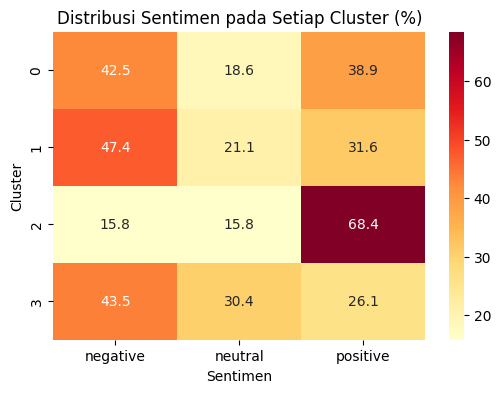

In [53]:

# ==================================================
# VISUALIZE CLUSTER DISTRIBUTION BY SENTIMENT
# ==================================================
cluster_sentiment = pd.crosstab(df['cluster'], df['label'], normalize='index') * 100

plt.figure(figsize=(6,4))
sns.heatmap(cluster_sentiment, annot=True, fmt='.1f', cmap='YlOrRd')
plt.title("Distribusi Sentimen pada Setiap Cluster (%)")
plt.xlabel("Sentimen")
plt.ylabel("Cluster")
plt.show()

In [54]:
# ==================================================
# MOST FREQUENT WORDS PER CLUSTER
# ==================================================
terms = tfidf.get_feature_names_out()

for c in sorted(df['cluster'].unique()):
    print(f"\n===== CLUSTER {c} =====")
    idx = df[df['cluster'] == c].index
    mean_tfidf = X[idx].mean(axis=0).A1
    top_terms = np.argsort(mean_tfidf)[-10:][::-1]

    for t in top_terms:
        print(terms[t])


===== CLUSTER 0 =====
error
login
masuk
suka
daftar
buka
wifi
akun
gabisa
baik

===== CLUSTER 1 =====
cerita
baca
bug
offline
update
baik
tulis
suka
hilang
baca offline

===== CLUSTER 2 =====
bagus
sinyal bagus
cerita
sinyal
suka
cerita bagus
baik
bug
lag
bagus bagus

===== CLUSTER 3 =====
iklan
baca
langgan
tiap
iklan iklan
baca iklan
bab
lanjut
langgan iklan
bayar


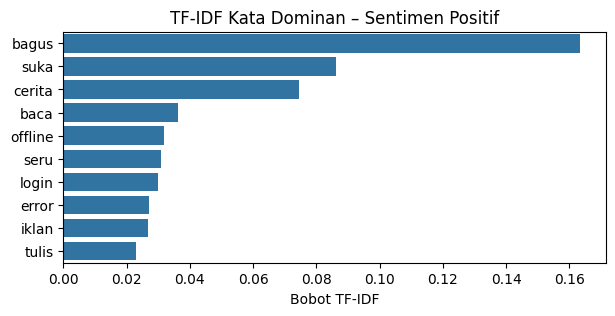

In [55]:
# ==================================================
# TF-IDF – POSITIVE SENTIMENT
# ==================================================

# Re-filter df_pos and df_neg with correct lowercase labels
df_pos = df[df['label'] == 'positive']
df_neg = df[df['label'] == 'negative']

tfidf_pos = TfidfVectorizer(max_features=1000)
X_pos = tfidf_pos.fit_transform(df_pos['cleaned_text'])

mean_pos = X_pos.mean(axis=0).A1
terms_pos = tfidf_pos.get_feature_names_out()

top_pos = np.argsort(mean_pos)[-10:][::-1]

plt.figure(figsize=(7,3))
sns.barplot(x=mean_pos[top_pos], y=[terms_pos[i] for i in top_pos])
plt.title("TF-IDF Kata Dominan – Sentimen Positif")
plt.xlabel("Bobot TF-IDF")
plt.show()

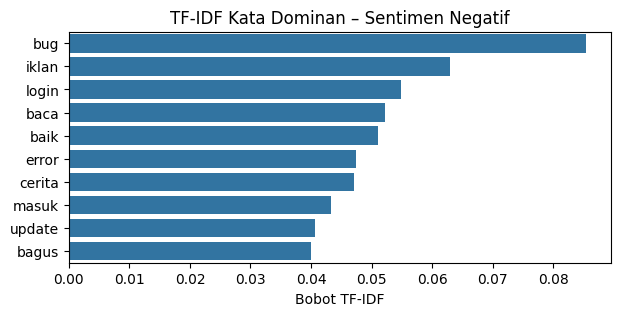

In [56]:
# ==================================================
# TF-IDF – NEGATIVE SENTIMENT
# ==================================================
tfidf_neg = TfidfVectorizer(max_features=1000)
X_neg = tfidf_neg.fit_transform(df_neg['cleaned_text'])

mean_neg = X_neg.mean(axis=0).A1
terms_neg = tfidf_neg.get_feature_names_out()

top_neg = np.argsort(mean_neg)[-10:][::-1]

plt.figure(figsize=(7,3))
sns.barplot(x=mean_neg[top_neg], y=[terms_neg[i] for i in top_neg])
plt.title("TF-IDF Kata Dominan – Sentimen Negatif")
plt.xlabel("Bobot TF-IDF")
plt.show()

In [57]:
# ==================================================
# TOPIC MODELING – LDA – TF-IDF
# ==================================================
texts = [t.split() for t in df['cleaned_text']]

dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=3, no_above=0.85)

corpus = [dictionary.doc2bow(text) for text in texts]

lda = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=4,
    passes=10,
    random_state=42
)

print("\n===== TOPIC MODELING LDA =====")
for i, topic in lda.print_topics(num_words=10):
    print(f"Topic {i}: {topic}")


===== TOPIC MODELING LDA =====
Topic 0: 0.093*"iklan" + 0.076*"cerita" + 0.050*"hilang" + 0.047*"error" + 0.041*"tulis" + 0.028*"seru" + 0.026*"simpan" + 0.026*"bug" + 0.025*"bab" + 0.023*"bagus"
Topic 1: 0.179*"baca" + 0.090*"cerita" + 0.072*"offline" + 0.051*"iklan" + 0.049*"tulis" + 0.034*"suka" + 0.020*"jadi" + 0.020*"update" + 0.018*"langgan" + 0.018*"hubung"
Topic 2: 0.106*"baik" + 0.075*"login" + 0.069*"bug" + 0.049*"akun" + 0.040*"wifi" + 0.039*"masuk" + 0.036*"sinyal" + 0.036*"bagus" + 0.033*"lama" + 0.031*"masalah"
Topic 3: 0.181*"bagus" + 0.095*"cerita" + 0.070*"suka" + 0.036*"bug" + 0.028*"waktu" + 0.027*"bintang" + 0.025*"the" + 0.025*"yaa" + 0.023*"keluar" + 0.020*"masuk"


In [58]:
# ==================================================
# SAVE RESULT
# ==================================================
df.to_csv("hasil_clustering_topic_modeling.csv", index=False)
print("\nAnalisis selesai & hasil disimpan.")



Analisis selesai & hasil disimpan.
